#### Example running SpaFHy with jupyter notebook

In [1]:
from model_driver import driver
from iotools import read_results
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import os

os.chdir(r'C:\SpaFHy_v1_Pallas_2D')

# example of calling driver, reading results
outputfile = driver(create_ncf=True, create_spinup=False, folder='testcase_input')
results = read_results(outputfile)

*** Defined soil IDs: {1.0, 2.0, 3.0, 4.0, 5.0} Used soil IDs: {1.0, 2.0, 4.0}
*** State variables assigned from parameters.py ***
*** Distributed radiation used ***
*** Simulation forced with: testcase_input\forcing\Kenttarova_forcing_era5.csv


C:\SpaFHy_v1_Pallas_2D\canopygrid.py:796: RuntimeWarning: invalid value encountered in arccos
  dl = 2.0*np.arccos(cosZEN - np.sin(LAT)*np.sin(DECL) / (np.cos(LAT)*np.cos(DECL))) / CF / 15.0  # hours


*** Running model ***
*** 2D run
Running timestep:  1
Timestep: 1 iterations 8 0.000874993015884229 -0.07466071799592555
Running timestep:  2


C:\SpaFHy_v1_Pallas_2D\canopygrid.py:723: RuntimeWarning: divide by zero encountered in divide
  rb = 1. / LAI * beta * ((w / Uh)*(alpha / (1.0 - np.exp(-alpha / 2.0))))**0.5


Timestep: 2 iterations 8 0.0005537428511956932 0.0016613479480156457
Running timestep:  3
Timestep: 3 iterations 6 0.0008308222364235007 -0.004661582905214345
Running timestep:  4
Timestep: 4 iterations 10 0.000796847814569901 -0.011453178920760365
Running timestep:  5
Timestep: 5 iterations 13 0.00024927740849989277 0.0005132717684546151
Running timestep:  6
Timestep: 6 iterations 8 0.0007719012589859631 -0.02236498504822748
Running timestep:  7
Timestep: 7 iterations 8 0.0006604776468748241 -0.007123281505187151
Running timestep:  8
Timestep: 8 iterations 9 0.0007513235307214927 -0.008198125295848513
Running timestep:  9
Timestep: 9 iterations 7 0.0008507773072210512 -0.006787113431585112
Running timestep:  10
Timestep: 10 iterations 13 0.0005015338864495789 -0.05561241820970508
Running timestep:  11
Timestep: 11 iterations 12 0.000339393288413703 -0.006780132300946207
Running timestep:  12
Timestep: 12 iterations 9 0.000500480139407955 -0.011068681664653468
Running timestep:  13
Tim

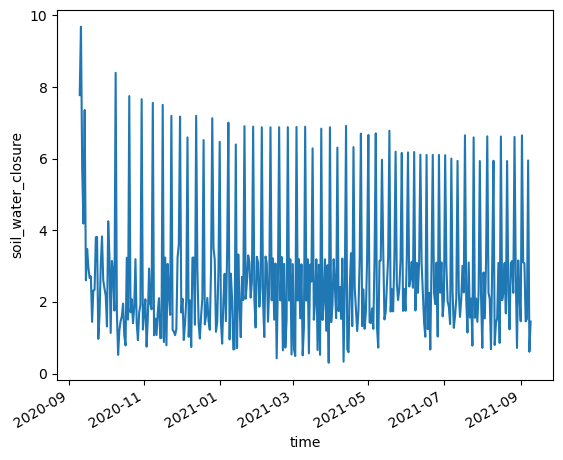

In [4]:
results['soil_water_closure'].max(dim=['lat','lon']).plot()